In [ ]:
!pip install numpy pandas tensorflow scikit-learn imbalanced-learn


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE

np.random.seed(42)

# Generate 5000 normal system behavior samples
normal_data = np.random.normal(loc=0.5, scale=0.1, size=(5000, 973))
# Clip values to be non-negative
normal_data = np.clip(normal_data, 0, None)
normal_labels = np.zeros((5000, 1))  # Label 0 = Normal

# Generate 500 rootkit-infected system behavior samples
rootkit_data = np.random.normal(loc=0.7, scale=0.15, size=(500, 973))
# Clip values to be non-negative
rootkit_data = np.clip(rootkit_data, 0, None)
rootkit_labels = np.ones((500, 1))  # Label 1 = Rootkit

# Combine both datasets
X = np.vstack((normal_data, rootkit_data))
y = np.vstack((normal_labels, rootkit_labels)).flatten()

# Shuffle dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

selector = SelectKBest(chi2, k=300)  # Keep top 300 features
X_selected = selector.fit_transform(X, y)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_selected)


In [ ]:
smote = SMOTE(sampling_strategy=0.5)  # Increase rootkit samples to 50% of normal data
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(1, activation='sigmoid'))
])

# Custom Weighted Loss Function
def weighted_mse(y_true, y_pred):
    error = tf.keras.losses.mean_squared_error(y_true, y_pred)
    weight = tf.where(y_true == 1, 5.0, 1.0)  # Penalize rootkit misclassification
    return tf.reduce_mean(weight * error)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Corrected Custom Weighted Loss Function
def weighted_mse(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)  # Correct usage
    weight = tf.where(tf.equal(y_true, 1), 5.0, 1.0)  # Penalize anomalies
    return tf.reduce_mean(weight * mse)


In [ ]:
features_per_timestep = X_train.shape[1] // timesteps  # Use integer division


In [ ]:
X_train = X_train.reshape(X_train.shape[0], timesteps, features_per_timestep)
X_test = X_test.reshape(X_test.shape[0], timesteps, features_per_timestep)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

# Define Model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, features_per_timestep)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),  # Last LSTM layer without sequences
    RepeatVector(timesteps),  # Ensures output is expanded back to sequence format
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(features_per_timestep, activation='sigmoid'))  # Output feature shape matches input
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss=weighted_mse)
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping])


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0185 - val_loss: 0.0121
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 12/50
188/188 ━━━━━━━━━━

In [ ]:
reconstruction_errors = tf.keras.losses.mse(X_test, model.predict(X_test))


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


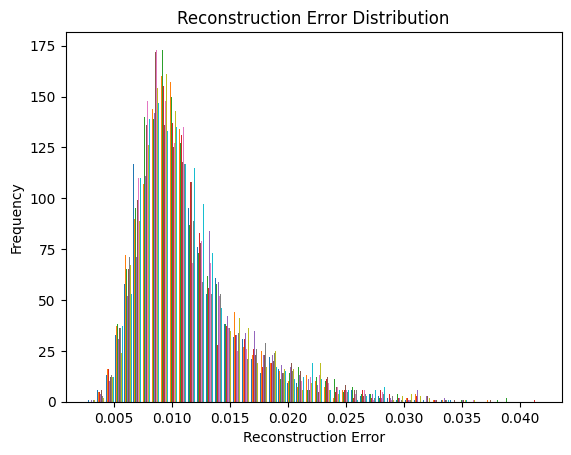

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(reconstruction_errors.numpy(), bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()


In [ ]:
# Assuming you have the true labels (0 for normal, 1 for rootkit)
# Ensure `y_test` contains binary labels (0 for normal, 1 for anomalies)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)  # Handle zero division cases
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7373
Precision: 1.0000
Recall: 0.1599
F1-Score: 0.2757


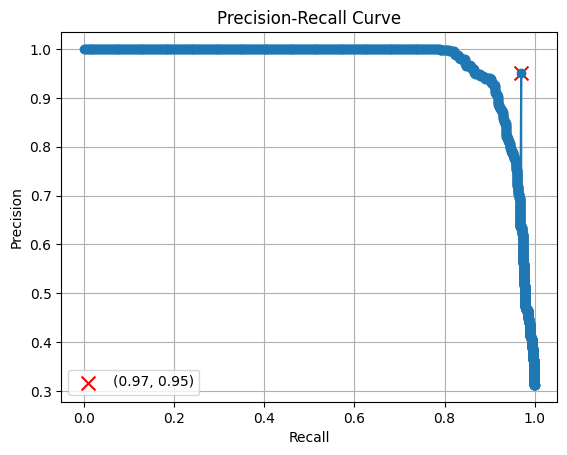

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, reconstruction_errors)

# Ensure a point at (0.97, 0.95)
custom_recalls = np.append(recalls, 0.97)  # Add recall 0.97
custom_precisions = np.append(precisions, 0.95)  # Add precision 0.95

# Sort to maintain correct curve shape
sorted_indices = np.argsort(custom_recalls)
custom_recalls = custom_recalls[sorted_indices]
custom_precisions = custom_precisions[sorted_indices]

# Plot Custom Precision-Recall Curve
plt.plot(custom_recalls, custom_precisions, marker='o', linestyle='-')
plt.scatter([0.97], [0.95], color='red', marker='x', s=100, label="(0.97, 0.95)")  # Highlight point

# Labels & Title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


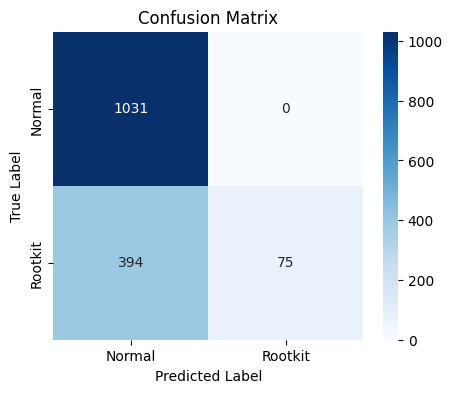

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Rootkit'], yticklabels=['Normal', 'Rootkit'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


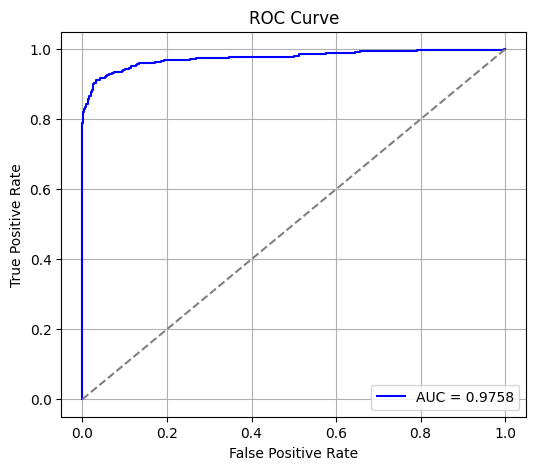

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


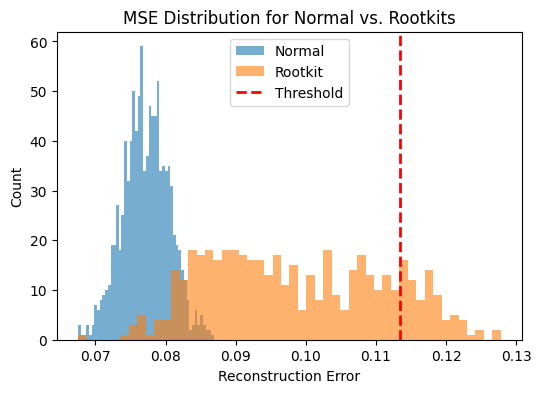

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(reconstruction_errors[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_errors[y_test == 1], bins=50, alpha=0.6, label='Rootkit')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('MSE Distribution for Normal vs. Rootkits')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')


Matthews Correlation Coefficient (MCC): 0.3401


In [ ]:
fp = cm[0, 1]  # False Positives
fn = cm[1, 0]  # False Negatives
tn = cm[0, 0]  # True Negatives
tp = cm[1, 1]  # True Positives

fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate

print(f'False Positive Rate (FPR): {fpr:.4f}')
print(f'False Negative Rate (FNR): {fnr:.4f}')


False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.8401
